<a href="https://colab.research.google.com/github/Manohar450/RL-project/blob/main/flappy_bird.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Episode 1/10, Total Reward: 343.0000000000083, Accuracy: 0.49
Episode 2/10, Total Reward: 343.0000000000083, Accuracy: 0.50
Episode 3/10, Total Reward: 343.0000000000083, Accuracy: 0.50
Episode 4/10, Total Reward: 343.0000000000083, Accuracy: 0.50
Episode 5/10, Total Reward: 343.0000000000083, Accuracy: 0.50
Episode 6/10, Total Reward: 343.0000000000083, Accuracy: 0.51
Episode 7/10, Total Reward: 343.0000000000083, Accuracy: 0.52
Episode 8/10, Total Reward: 343.0000000000083, Accuracy: 0.51
Episode 9/10, Total Reward: 343.0000000000083, Accuracy: 0.53
Episode 10/10, Total Reward: 343.0000000000083, Accuracy: 0.52


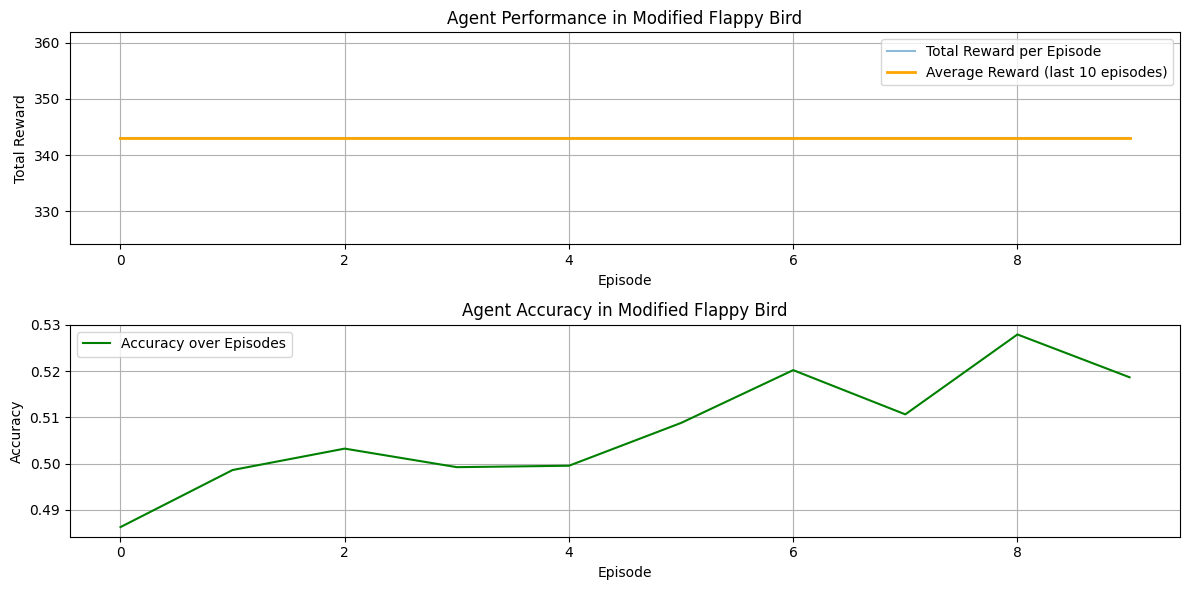

   Episode  Total Reward  Average Reward (last 10)  Accuracy
0        1         343.0                     343.0  0.486261
1        2         343.0                     343.0  0.498611
2        3         343.0                     343.0  0.503242
3        4         343.0                     343.0  0.499228
4        5         343.0                     343.0  0.499537
5        6         343.0                     343.0  0.508799
6        7         343.0                     343.0  0.520222
7        8         343.0                     343.0  0.510651
8        9         343.0                     343.0  0.527941
9       10         343.0                     343.0  0.518679


In [9]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from collections import deque
import random
import pandas as pd
import matplotlib.pyplot as plt

# Load the dataset (make sure this path is correct)
data = pd.read_csv('/content/flappy_bird.csv.zip')

# Preprocessing: Normalize the features
features = ['last_pipe_horizontal_position', 'last_top_pipe_vertical_position',
            'last_bottom_pipe_vertical_position', 'next_pipe_horizontal_position',
            'next_top_pipe_vertical_position', 'next_bottom_pipe_vertical_position',
            'next_next_pipe_horizontal_position', 'next_next_top_pipe_vertical_position',
            'next_next_bottom_pipe_vertical_position', 'player_s_vertical_position',
            'player_s_vertical_velocity', 'player_s_rotation']

data[features] = data[features].apply(lambda x: (x - x.mean()) / x.std())

# Use a smaller subset of the data for quick testing
data_subset = data.sample(frac=0.1, random_state=42)  # Use 10% of the data

states = data_subset[features].values
actions = data_subset['action'].values
rewards = data_subset['reward'].values

# Split the dataset into training and validation sets
train_size = int(0.8 * len(states))
train_states, test_states = states[:train_size], states[train_size:]
train_actions, test_actions = actions[:train_size], actions[train_size:]
train_rewards, test_rewards = rewards[:train_size], rewards[train_size:]

class ReplayBuffer:
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)

    def push(self, state, action, reward, next_state, done):
        self.buffer.append((state, action, reward, next_state, done))

    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)

    def __len__(self):
        return len(self.buffer)

class DQN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(DQN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, output_dim)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

class DQNAgent:
    def __init__(self, input_dim, output_dim):
        self.policy_net = DQN(input_dim, output_dim)
        self.target_net = DQN(input_dim, output_dim)
        self.target_net.load_state_dict(self.policy_net.state_dict())
        self.target_net.eval()

        self.optimizer = optim.Adam(self.policy_net.parameters())
        self.memory = ReplayBuffer(10000)
        self.batch_size = 32
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995

    def select_action(self, state):
        if random.random() < self.epsilon:
            return random.randint(0, 1)  # Random action (flap or no flap)
        else:
            state_tensor = torch.FloatTensor(state).unsqueeze(0)
            q_values = self.policy_net(state_tensor)
            return q_values.argmax().item()

    def train(self):
        if len(self.memory) < self.batch_size:
            return

        batch = self.memory.sample(self.batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)

        # Convert lists to numpy arrays before converting to tensors
        states = torch.FloatTensor(np.array(states))
        actions = torch.LongTensor(np.array(actions))
        rewards = torch.FloatTensor(np.array(rewards))
        next_states = torch.FloatTensor(np.array(next_states))
        dones = torch.FloatTensor(np.array(dones))

        current_q_values = self.policy_net(states).gather(1, actions.unsqueeze(1)).squeeze(1)
        next_q_values = self.target_net(next_states).max(1)[0]
        expected_q_values = rewards + self.gamma * next_q_values * (1 - dones)

        loss = nn.MSELoss()(current_q_values, expected_q_values)

        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

    def update_target_network(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    def update_epsilon(self):
        self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)

# Training the agent using the dataset
agent = DQNAgent(input_dim=len(features), output_dim=2)

num_episodes = 10  # Reduced number of episodes for quicker testing

# Metrics to track
episode_rewards = []  # Total rewards per episode
average_rewards = []  # Average rewards over last 10 episodes
accuracy_scores = []  # Accuracy over episodes

for episode in range(num_episodes):
    total_reward = 0
    correct_predictions = 0
    for i in range(len(train_states) - 1):
        state = train_states[i]
        next_state = train_states[i + 1]
        action = train_actions[i]
        reward = train_rewards[i]
        done = i == (len(train_states) - 2)

        agent.memory.push(state, action, reward, next_state, done)
        total_reward += reward

        if len(agent.memory) >= agent.batch_size:
            agent.train()

        # Calculate accuracy: Compare predicted action with actual action
        predicted_action = agent.select_action(state)
        if predicted_action == action:
            correct_predictions += 1

    agent.update_epsilon()

    if episode % 10 == 0:
        agent.update_target_network()

    # Collect metrics
    episode_rewards.append(total_reward)
    average_rewards.append(np.mean(episode_rewards[-10:]))  # Average of last 10 episodes
    accuracy = correct_predictions / len(train_states)
    accuracy_scores.append(accuracy)

    print(f'Episode {episode+1}/{num_episodes}, Total Reward: {total_reward}, Accuracy: {accuracy:.2f}')

# Plotting the results
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(episode_rewards, label='Total Reward per Episode', alpha=0.5)
plt.plot(average_rewards, label='Average Reward (last 10 episodes)', color='orange', linewidth=2)
plt.title('Agent Performance in Modified Flappy Bird')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.legend()
plt.grid()

plt.subplot(2, 1, 2)
plt.plot(accuracy_scores, label='Accuracy over Episodes', color='green')
plt.title('Agent Accuracy in Modified Flappy Bird')
plt.xlabel('Episode')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()

plt.tight_layout()
plt.show()

# Create a DataFrame to summarize results
results_df = pd.DataFrame({
    'Episode': range(1, num_episodes + 1),
    'Total Reward': episode_rewards,
    'Average Reward (last 10)': average_rewards,
    'Accuracy': accuracy_scores
})

# Display the DataFrame
print(results_df.head(20))  # Show the first 20 entries


